In [30]:
import os
import warnings
from pathlib import Path

import lightgbm
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.metrics import roc_auc_score

import src.features.basic as ftr_basic
import src.models.training as train_model
import src.utils.io as io_utils
import src.visualization.plotting as visual

In [18]:
load_dotenv()
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2


ROOT = Path(os.getenv("ROOT"))
CONFIG_DIR = ROOT / Path("src/config/")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
data_cfg = io_utils.load_yaml(CONFIG_DIR / "data.yaml")
DATA_NEW_FTR = data_cfg["new_features_train_data"]

data_train = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["train_new_features_path"])
data_val = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["val_new_features_path"])

target_train = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["train_target_path"])
target_val = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["val_target_path"])

data_ids = io_utils.load_df_parquet(
    ROOT / data_cfg["origin_train_data_clean"]["ids_path"]
)

data_train.head()

,age,job,marital,education,contact,poutcome,was_contact,credit_score,job_marital,job_education,...,previous_cat,log_duration,log_balance,multiply_logs,is_overdraft,sin_month,cos_month,sin_day,cos_day,jb_mean
0,30,blue-collar,married,primary,unknown,unknown,0,1,blue-collar_married,blue-collar_primary,...,0,5.697093,7.300473,41.591476,0,0.866025,-0.500000,0.299363,-0.954139,972.500400
1,33,technician,divorced,secondary,cellular,unknown,0,0,technician_divorced,technician_secondary,...,0,6.137727,3.871201,23.760375,0,-0.500000,-0.866025,0.937752,0.347305,1073.106634
2,28,blue-collar,single,primary,telephone,unknown,0,1,blue-collar_single,blue-collar_primary,...,0,6.276643,6.318968,39.661910,0,0.866025,-0.500000,0.651372,-0.758758,972.500400
3,29,unemployed,single,primary,cellular,unknown,0,0,unemployed_single,unemployed_primary,...,0,5.468060,7.635787,41.752942,0,0.500000,0.866025,0.394356,0.918958,1429.215033
4,55,technician,married,secondary,cellular,success,1,1,technician_married,technician_secondary,...,<5,6.419995,6.763885,43.424107,0,0.500000,-0.866025,0.988468,0.151428,1073.106634


In [8]:
ftr_names = ftr_basic.get_features_names(data_train)
cat_features, num_features = ftr_names["categorical"], ftr_names["numeric"]

data_train = ftr_basic.cat_features_to_category(data_train)
data_val = ftr_basic.cat_features_to_category(data_val)

data_train, data_val = ftr_basic.align_categorical_levels(
    data_train, data_val, cat_features
)

In [9]:
cat_features

['job',
 'marital',
 'education',
 'contact',
 'poutcome',
 'job_marital',
 'job_education',
 'education_marital',
 'campaign_cat',
 'pdays_cat',
 'previous_cat']

In [20]:
model_cfg = io_utils.load_yaml(CONFIG_DIR / "models.yml")["lgbm_searh"]

PARAMS_PATH = ROOT / model_cfg["params_path"]
params = io_utils.load_yaml(PARAMS_PATH)
lgbm_base_params = params["params"]
rand_search_param = params["randomized"]

lgbm_base_params

{'objective': 'binary',
 'metric': 'auc',
 'n_estimators': 10000,
 'class_weight': 'balanced',
 'random_state': 42,
 'n_jobs': -1}

In [17]:
n_iter = rand_search_param["n_iter"]
cv = rand_search_param["cv"]

In [22]:
%%time

train_pool_lgbm = data_train, target_train
val_pool_lgbm = data_val, target_val

best_lgbm = train_model.random_search_cv_lgbm(
    train_pool_lgbm,
    cat_features,
    lgbm_base_params,
    val_pool_lgbm,
    n_iter,
    cv,
    refit=True,
    random_seed=RANDOM_STATE,
)

=============== comb params 1/24 ===============
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7282532043662948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7282532043662948
[LightGBM] [Warning] bagging_fraction is set=0.9926867054910268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9926867054910268
[LightGBM] [Warning] min_data_in_leaf is set=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7282532043662948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7282532043662948
[LightGBM] [Warning] bagging_fraction is set=0.9926867054910268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9926867054910268
[LightGBM

AttributeError: 'LGBMClassifier' object has no attribute 'save_model'

In [23]:
num_iter = getattr(best_lgbm, "best_iteration_", None)  # int или None
best_lgbm.booster_.save_model(ROOT / model_cfg["model_path"], num_iteration=num_iter)

In [27]:
best_params_lgbm = best_lgbm.get_params()
best_iter_lgbm = num_iter
print("best_params: ", best_params_lgbm)
print(f"best iteration: {best_iter_lgbm}")

pred_best_lgbm = best_lgbm.predict_proba(data_val)[:, 1]
auc = roc_auc_score(target_val, pred_best_lgbm)
print(f"Best LGBM AUC: {auc:.4f}")

best_params:  {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 106, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.5214297905300546, 'reg_lambda': 1.236243687952708, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'auc', 'min_data_in_leaf': 137, 'feature_fraction': 0.7282532043662948, 'bagging_fraction': 0.9926867054910268, 'bagging_freq': 2, 'max_cat_to_onehot': 6, 'cat_l2': 19.205212018125557, 'cat_smooth': 228.1355236625612}
best iteration: 2764
Best LGBM AUC: 0.9680


In [31]:
meta = {
    "library": "LightGBM",
    "version": lightgbm.__version__,
    "base_params": lgbm_base_params,
    "best_search_params": best_params_lgbm,
    "best_iteration": best_iter_lgbm,
    "tree_count": best_iter_lgbm + 1,
    "feature_order": list(data_train.columns),
    "categorical_features": list(cat_features),
}

io_utils.save_yaml(meta, ROOT / model_cfg["meta_path"])

In [32]:
metrics = {"auc_val": float(auc)}
preds_df = pd.DataFrame(
    {
        "val_ids": data_ids.loc[data_val.index, "id"],
        "val_preds": pred_best_lgbm,
        "val_true": target_val.squeeze(),
    }
)

io_utils.save_df_parquet(preds_df, ROOT / model_cfg["preds_path"])
io_utils.save_yaml(metrics, ROOT / model_cfg["metrics_path"])

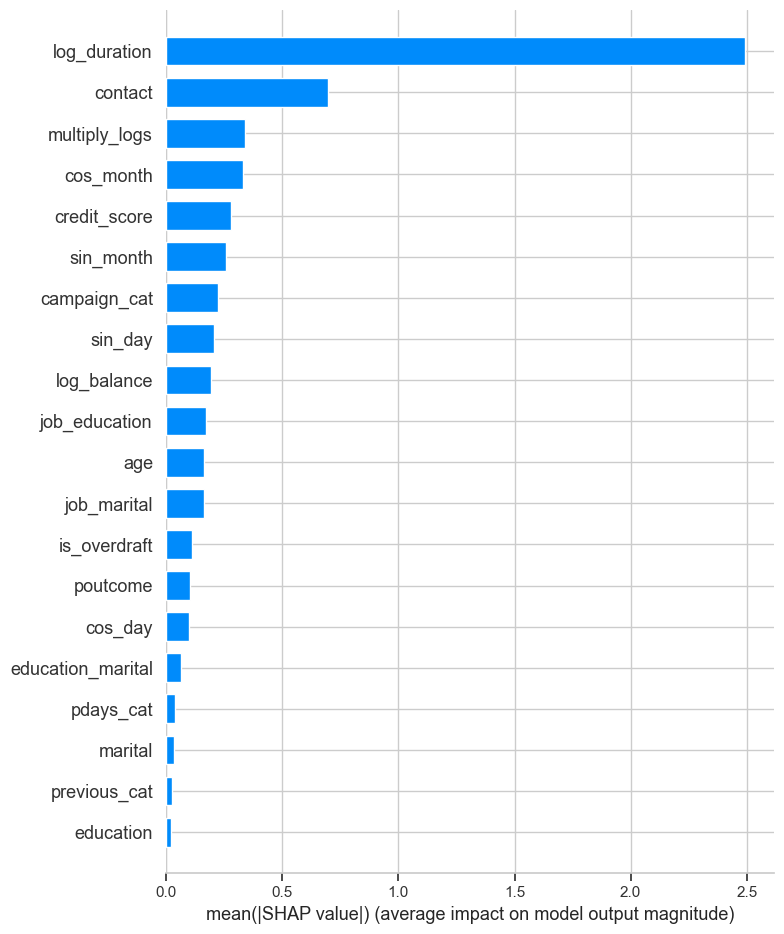

,feature,shap_value
14,log_duration,2.492747
4,contact,0.697729
16,multiply_logs,0.338148
19,cos_month,0.330100
7,credit_score,0.279030
18,sin_month,0.257648
11,campaign_cat,0.223823
20,sin_day,0.204062
15,log_balance,0.190997
9,job_education,0.169321


In [29]:
shap_values = visual.shap_values(best_lgbm, data_train)

shap_values